In [32]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lychee
import pandas as pd
from scipy import stats
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MI computation

In [2]:
smp = np.random.choice(2, 10)


def get_entropy_from_freq(freq):
    prob = freq / np.sum(freq)
    return -np.sum(prob * np.log2(prob))


def get_entropy(smp):
    freq = np.bincount(smp)
    return get_entropy_from_freq(freq)


print("Entropy of a random sample of 2 values: ")
print(get_entropy(np.random.choice(2, 10000)))


def get_mi(smptup):
    tup, cnt = np.unique(smptup, axis=0, return_counts=True)
    hxy = get_entropy_from_freq(cnt)
    unique_x = np.unique(tup[:, 0])
    freq_x = [np.sum(cnt[tup[:, 0] == x]) for x in unique_x]
    hx = get_entropy_from_freq(freq_x)
    unique_y = np.unique(tup[:, 1])
    freq_y = [np.sum(cnt[tup[:, 1] == y]) for y in unique_y]
    hy = get_entropy_from_freq(freq_y)
    return hx + hy - hxy


def get_mi_emp(smptup):
    return get_mi(smptup)


def get_mi_miller(smptup):
    mi_emp = get_mi_emp(smptup)
    num_nonzero_x = len(np.unique(smptup[:, 0]))
    num_nonzero_y = len(np.unique(smptup[:, 1]))
    return mi_emp - (num_nonzero_x - 1) * (num_nonzero_y - 1) / (
        2 * len(smptup)
    )


def get_mi_chao(smptup, domain_size, debug=False):
    sample_matrix = np.zeros((domain_size, domain_size))
    for i in range(len(smptup)):
        sample_matrix[smptup[i][0], smptup[i][1]] += 1
    # ChaoSRM: is_flat = False, is_adjust = True, is_muller = True
    return lychee.lychee(sample_matrix, False, True, True, debug)


print("Mutual information of two independent random samples of 2 values: ")
smp1 = np.random.choice(2, 10000)
smp2 = np.random.choice(2, 10000)
smptup = np.vstack((smp1, smp2)).T
print(get_mi(smptup))

Entropy of a random sample of 2 values: 
0.9998665754494069
Mutual information of two independent random samples of 2 values: 
5.628043195704535e-06


# Crypto1

In [3]:
state_length = 48
domain_size = 2

In [4]:
def fa(a, b, c, d, m=domain_size):
    # ((a || b) ^ (a && d)) ^ (c && ((a ^ b) || d))
    return ((a or b) ^ (a and d)) ^ (c and ((a ^ b) or d))


def fb(a, b, c, d, m=domain_size):
    # ((a && b) || c) ^ ((a ^ b) && (c || d))
    return ((a and b) or c) ^ ((a ^ b) and (c or d))


def fc(a, b, c, d, e, m=domain_size):
    # (a || ((b || e) && (d ^ e))) ^ ((a ^ (b && d)) && ((c ^ d) || (b && e)))
    return (a or ((b or e) and (d ^ e))) ^ (
        (a ^ (b and d)) and ((c ^ d) or (b and e))
    )

In [5]:
fa1idxs = [9, 11, 13, 15]
fb2idxs = [17, 19, 21, 23]
fb3idxs = [25, 27, 29, 31]
fa4idxs = [33, 35, 37, 39]
fb5idxs = [41, 43, 45, 47]


def get_obs(state):
    return fc(
        fa(*[state[i] for i in fa1idxs]),
        fb(*[state[i] for i in fb2idxs]),
        fb(*[state[i] for i in fb3idxs]),
        fa(*[state[i] for i in fa4idxs]),
        fb(*[state[i] for i in fb5idxs]),
    )

In [6]:
initial_state = np.random.choice(domain_size, state_length)
get_obs(initial_state)

0

In [7]:
target_idx = 5
sample_size = 100
data = []
for _ in range(sample_size):
    sec = np.random.randint(2)
    state = np.copy(initial_state)
    if sec:
        initial_state[target_idx] = int(not initial_state[target_idx])
    obs = get_obs(state)
    data.append((sec, obs))
data = np.array(data)
print(f"MI for {target_idx=}: {get_mi(data)}")

MI for target_idx=5: 0.0


In [8]:
num_state = 10000

raw_data = {idx: [] for idx in range(state_length)}
for iter_idx in range(num_state):
    print(f"{iter_idx=}/{num_state=}", end="\r")
    initial_state = np.random.choice(domain_size, state_length)
    init_obs = get_obs(initial_state)
    for target_idx in range(state_length):
        sec = np.random.randint(domain_size)
        if sec:
            flipped_state = np.copy(initial_state)
            flipped_state[target_idx] += sec
            flipped_state[target_idx] %= domain_size
            flip_obs = get_obs(flipped_state)
            diff = (flip_obs - init_obs) % domain_size
            raw_data[target_idx].append((iter_idx, sec, diff))
        else:
            raw_data[target_idx].append((iter_idx, 0, 0))
for idx in range(state_length):
    raw_data[idx] = np.array(raw_data[idx])
print(raw_data[0].shape)

(10000, 3)999/num_state=10000


In [9]:
for idx in range(state_length):
    raw_data_of_idx = raw_data[idx]
    mi_from_raw_data = get_mi(raw_data_of_idx[:, 1:])
    print(f"{idx=}: {mi_from_raw_data:.2e}")

idx=0: 0.00e+00
idx=1: 0.00e+00
idx=2: 0.00e+00
idx=3: 0.00e+00
idx=4: 0.00e+00
idx=5: 0.00e+00
idx=6: 0.00e+00
idx=7: 0.00e+00
idx=8: 0.00e+00
idx=9: 1.31e-01
idx=10: 0.00e+00
idx=11: 1.36e-01
idx=12: 0.00e+00
idx=13: 2.20e-01
idx=14: 0.00e+00
idx=15: 1.33e-01
idx=16: 0.00e+00
idx=17: 1.60e-01
idx=18: 0.00e+00
idx=19: 1.57e-01
idx=20: 0.00e+00
idx=21: 9.76e-02
idx=22: 0.00e+00
idx=23: 4.78e-02
idx=24: 0.00e+00
idx=25: 1.57e-01
idx=26: 0.00e+00
idx=27: 1.61e-01
idx=28: 0.00e+00
idx=29: 1.01e-01
idx=30: 0.00e+00
idx=31: 4.84e-02
idx=32: 0.00e+00
idx=33: 1.72e-01
idx=34: 0.00e+00
idx=35: 1.73e-01
idx=36: 0.00e+00
idx=37: 2.83e-01
idx=38: 0.00e+00
idx=39: 1.79e-01
idx=40: 0.00e+00
idx=41: 1.53e-01
idx=42: 0.00e+00
idx=43: 1.58e-01
idx=44: 0.00e+00
idx=45: 1.00e-01
idx=46: 0.00e+00
idx=47: 4.61e-02


Text(0, 0.5, 'Mutual Information')

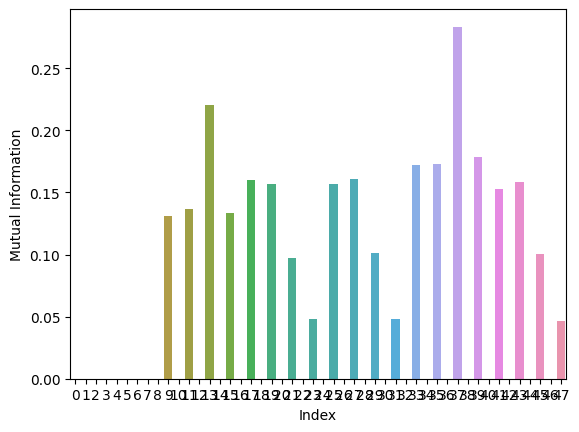

In [10]:
# draw boxplot of mi_data
fig, ax = plt.subplots()
sns.barplot(
    x=[idx for idx in range(state_length)],
    y=[get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)],
    ax=ax,
)
ax.set_xlabel("Index")
ax.set_ylabel("Mutual Information")

# Crypto*

In [11]:
state_length = 24
domain_size = 2 ** 4

In [12]:
# a  or b -> a ** (b + 1)
# a and b -> a * b
# a xor b -> a + b


def anding(a, b, m=domain_size):
    return (a * b) % m


def oring(a, b, m=domain_size):
    return (a ** ((b + 1) % m)) % m


def xoring(a, b, m=domain_size):
    return (a + b) % m


def fa(a, b, c, d, m=domain_size):
    # ((a || b) ^ (a && d)) ^ (c && ((a ^ b) || d))
    return xoring(
        (oring(a, b) ^ anding(a, d)), anding(c, oring(xoring(a, b), d))
    )


def fb(a, b, c, d, m=domain_size):
    # ((a && b) || c) ^ ((a ^ b) && (c || d))
    return xoring((oring(anding(a, b), c)), anding(xoring(a, b), oring(c, d)))


# def fc(a, b, c, d, e, m=domain_size):
#     # (a || ((b || e) && (d ^ e))) ^ ((a ^ (b && d)) && ((c ^ d) || (b && e)))
#     return xoring(
#         (oring(a, anding(oring(b, e), xoring(d, e)))),
#         anding(
#             xoring(a, anding(b, d)),
#             oring(xoring(c, d), anding(b, e)),
#         ),
#     )


def fc(a, b, c, d, e, m=domain_size):
    # a ^ b ^ c ^ d ^ e
    return xoring(xoring(xoring(xoring(a, b), c), d), e)
    # return anding(xoring(xoring(xoring(a, anding(b, 1)), c), oring(d, 3)), e)

In [13]:
fa1idxs = [4, 5, 6, 7]
fb2idxs = [8, 9, 10, 11]
fb3idxs = [12, 13, 14, 15]
fa4idxs = [16, 17, 18, 19]
fb5idxs = [20, 21, 22, 23]


def get_obs(state):
    return fc(
        fa(*[state[i] for i in fa1idxs]),
        fb(*[state[i] for i in fb2idxs]),
        fb(*[state[i] for i in fb3idxs]),
        fa(*[state[i] for i in fa4idxs]),
        fb(*[state[i] for i in fb5idxs]),
    )

Entropy of the output: 3.998440138993273


<AxesSubplot: ylabel='Count'>

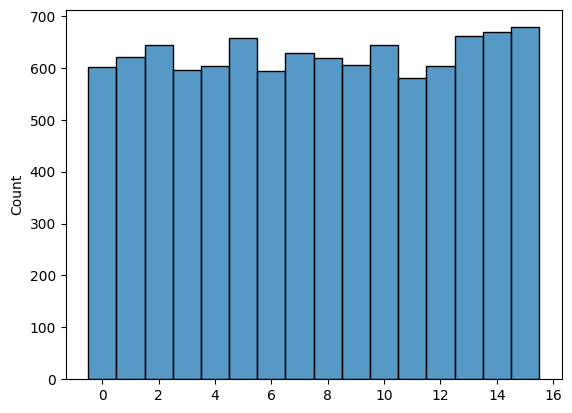

In [14]:
num_state = 10000
data = []
for _ in range(num_state):
    init_state = np.random.choice(domain_size, state_length)
    data.append(get_obs(init_state))
data = np.array(data)
print(f"Entropy of the output: {get_entropy(data)}")

fig, ax = plt.subplots()
sns.histplot(data, discrete=True, ax=ax)

In [15]:
num_state = 10000

raw_data = {idx: [] for idx in range(state_length)}
for iter_idx in range(num_state):
    print(f"{iter_idx=}/{num_state=}", end="\r")
    initial_state = np.random.choice(domain_size, state_length)
    init_obs = get_obs(initial_state)
    for target_idx in range(state_length):
        sec = np.random.randint(domain_size)
        if sec:
            flipped_state = np.copy(initial_state)
            flipped_state[target_idx] += sec
            flipped_state[target_idx] %= domain_size
            flip_obs = get_obs(flipped_state)
            diff = (flip_obs - init_obs) % domain_size
            raw_data[target_idx].append((iter_idx, sec, diff))
        else:
            raw_data[target_idx].append((iter_idx, 0, 0))
for idx in range(state_length):
    raw_data[idx] = np.array(raw_data[idx])
print(raw_data[0].shape)

(10000, 3)999/num_state=10000


idx=0: 0.00e+00
idx=1: 0.00e+00
idx=2: 0.00e+00
idx=3: 0.00e+00
idx=4: 6.46e-01
idx=5: 4.21e-01
idx=6: 1.03e+00
idx=7: 5.87e-01
idx=8: 8.48e-01
idx=9: 8.62e-01
idx=10: 4.79e-01
idx=11: 1.31e-01
idx=12: 8.75e-01
idx=13: 8.84e-01
idx=14: 4.64e-01
idx=15: 1.43e-01
idx=16: 6.55e-01
idx=17: 4.56e-01
idx=18: 1.02e+00
idx=19: 5.82e-01
idx=20: 8.49e-01
idx=21: 8.50e-01
idx=22: 4.78e-01
idx=23: 1.47e-01


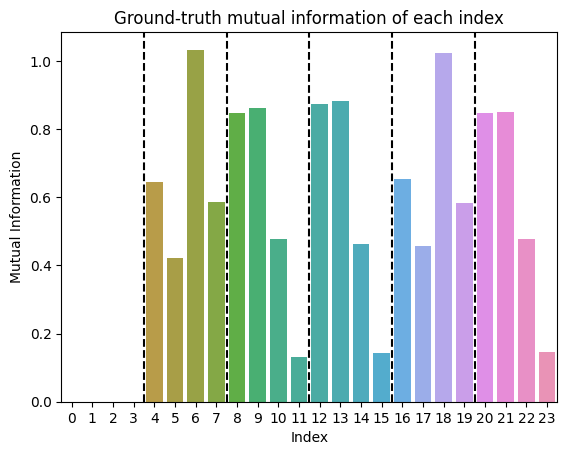

In [27]:
mis_gt = [get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)]

for idx in range(state_length):
    # raw_data_of_idx = raw_data[idx]
    # mi_from_raw_data = get_mi(raw_data_of_idx[:, 1:])
    print(f"{idx=}: {mis_gt[idx]:.2e}")

fig, ax = plt.subplots()
sns.barplot(
    x=[idx for idx in range(state_length)],
    y=[get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)],
    ax=ax,
)
ax.set_xlabel("Index")
ax.set_ylabel("Mutual Information")
ax.set_title("Ground-truth mutual information of each index")
for i in range(1, 6):
    ax.axvline(4 * i - 0.5, color="black", linestyle="--")
plt.savefig("figures/rebuttal/ground-truth-mi.png")
plt.show()

# index_rank = np.argsort([get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)])
# print(index_rank)

(10000, 3)999/num_state=10000


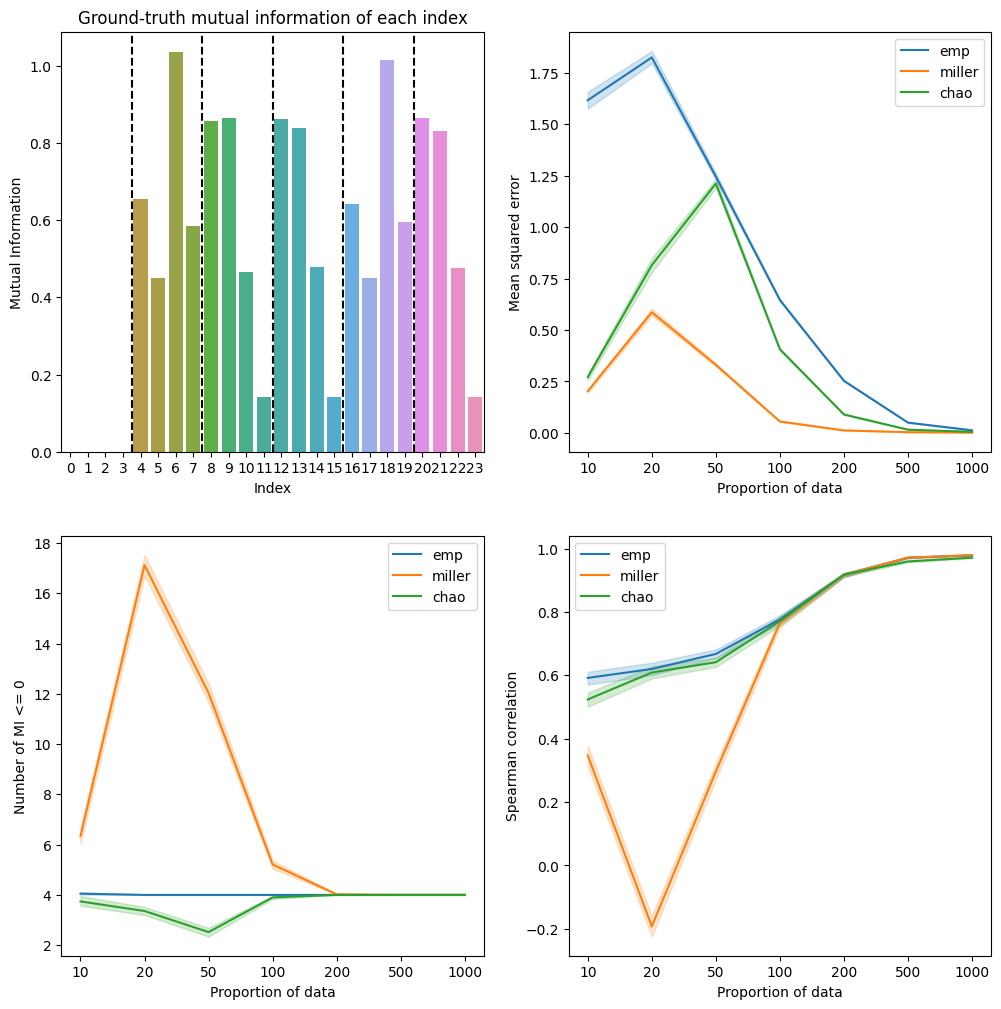

In [47]:
num_state = 10000

raw_data = {idx: [] for idx in range(state_length)}
for iter_idx in range(num_state):
    print(f"{iter_idx=}/{num_state=}", end="\r")
    initial_state = np.random.choice(domain_size, state_length)
    init_obs = get_obs(initial_state)
    for target_idx in range(state_length):
        sec = np.random.randint(domain_size)
        if sec:
            flipped_state = np.copy(initial_state)
            flipped_state[target_idx] += sec
            flipped_state[target_idx] %= domain_size
            flip_obs = get_obs(flipped_state)
            diff = (flip_obs - init_obs) % domain_size
            raw_data[target_idx].append((iter_idx, sec, diff))
        else:
            raw_data[target_idx].append((iter_idx, 0, 0))
for idx in range(state_length):
    raw_data[idx] = np.array(raw_data[idx])
print(raw_data[0].shape)

mis_gt = [get_mi(raw_data[idx][:, 1:]) for idx in range(state_length)]

# draw boxplot of mi_data
runs = 100
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1]
len_prop_ratios = len(prop_ratios)
data = []
data2 = []
data3 = []
for prop_ratio in prop_ratios:
    for _ in range(runs):
        subsample_size = int(num_state * prop_ratio)
        subsample_idxs = np.random.choice(
            num_state, subsample_size, replace=False
        )
        mis_emp = [
            get_mi_emp(raw_data[idx][subsample_idxs, 1:])
            for idx in range(state_length)
        ]
        mis_miller = [
            get_mi_miller(raw_data[idx][subsample_idxs, 1:])
            for idx in range(state_length)
        ]
        mis_chao = [
            get_mi_chao(
                raw_data[idx][subsample_idxs, 1:], domain_size, debug=False
            )
            for idx in range(state_length)
        ]
        data.append(
            {
                "sample_size": subsample_size,
                "emp": stats.spearmanr(mis_gt, mis_emp).correlation,
                "miller": stats.spearmanr(mis_gt, mis_miller).correlation,
                "chao": stats.spearmanr(mis_gt, mis_chao).correlation,
            }
        )
        data2.append(
            {
                "sample_size": subsample_size,
                "emp": np.mean((np.array(mis_gt) - np.array(mis_emp)) ** 2),
                "miller": np.mean(
                    (np.array(mis_gt) - np.array(mis_miller)) ** 2
                ),
                "chao": np.mean((np.array(mis_gt) - np.array(mis_chao)) ** 2),
            }
        )
        data3.append(
            {
                "sample_size": subsample_size,
                "emp": np.sum([mi <= 0 for mi in mis_emp]),
                "miller": np.sum([mi <= 0 for mi in mis_miller]),
                "chao": np.sum([mi <= 0 for mi in mis_chao]),
            }
        )
df_corr = pd.DataFrame(data, columns=["sample_size", "emp", "miller", "chao"])
df_corr["sample_size"] = df_corr["sample_size"].astype(str)
df_mse = pd.DataFrame(data2, columns=["sample_size", "emp", "miller", "chao"])
df_mse["sample_size"] = df_mse["sample_size"].astype(str)
df_zero = pd.DataFrame(data3, columns=["sample_size", "emp", "miller", "chao"])
df_zero["sample_size"] = df_zero["sample_size"].astype(str)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.barplot(
    x=[idx for idx in range(state_length)],
    y=mis_gt,
    ax=axes[0, 0],
)
axes[0, 0].set_xlabel("Index")
axes[0, 0].set_ylabel("Mutual Information")
axes[0, 0].set_title("Ground-truth mutual information of each index")
for i in range(1, 6):
    axes[0, 0].axvline(4 * i - 0.5, color="black", linestyle="--")

sns.lineplot(data=df_mse, x="sample_size", y="emp", ax=axes[0, 1], label="emp")
sns.lineplot(
    data=df_mse, x="sample_size", y="miller", ax=axes[0, 1], label="miller"
)
sns.lineplot(
    data=df_mse, x="sample_size", y="chao", ax=axes[0, 1], label="chao"
)
axes[0, 1].set_xlabel("Proportion of data")
axes[0, 1].set_ylabel("Mean squared error")

sns.lineplot(data=df_zero, x="sample_size", y="emp", ax=axes[1, 0], label="emp")
sns.lineplot(
    data=df_zero, x="sample_size", y="miller", ax=axes[1, 0], label="miller"
)
sns.lineplot(
    data=df_zero, x="sample_size", y="chao", ax=axes[1, 0], label="chao"
)
axes[1, 0].set_xlabel("Proportion of data")
axes[1, 0].set_ylabel("Number of MI <= 0")

sns.lineplot(data=df_corr, x="sample_size", y="emp", ax=axes[1, 1], label="emp")
sns.lineplot(
    data=df_corr, x="sample_size", y="miller", ax=axes[1, 1], label="miller"
)
sns.lineplot(
    data=df_corr, x="sample_size", y="chao", ax=axes[1, 1], label="chao"
)
axes[1, 1].set_xlabel("Proportion of data")
axes[1, 1].set_ylabel("Spearman correlation")

os.makedirs("figures/rebuttal", exist_ok=True)
df_mse.to_csv("figures/rebuttal/mse.csv", index=False)
df_zero.to_csv("figures/rebuttal/zero.csv", index=False)
df_corr.to_csv("figures/rebuttal/corr.csv", index=False)
plt.savefig("figures/rebuttal/stat.png")

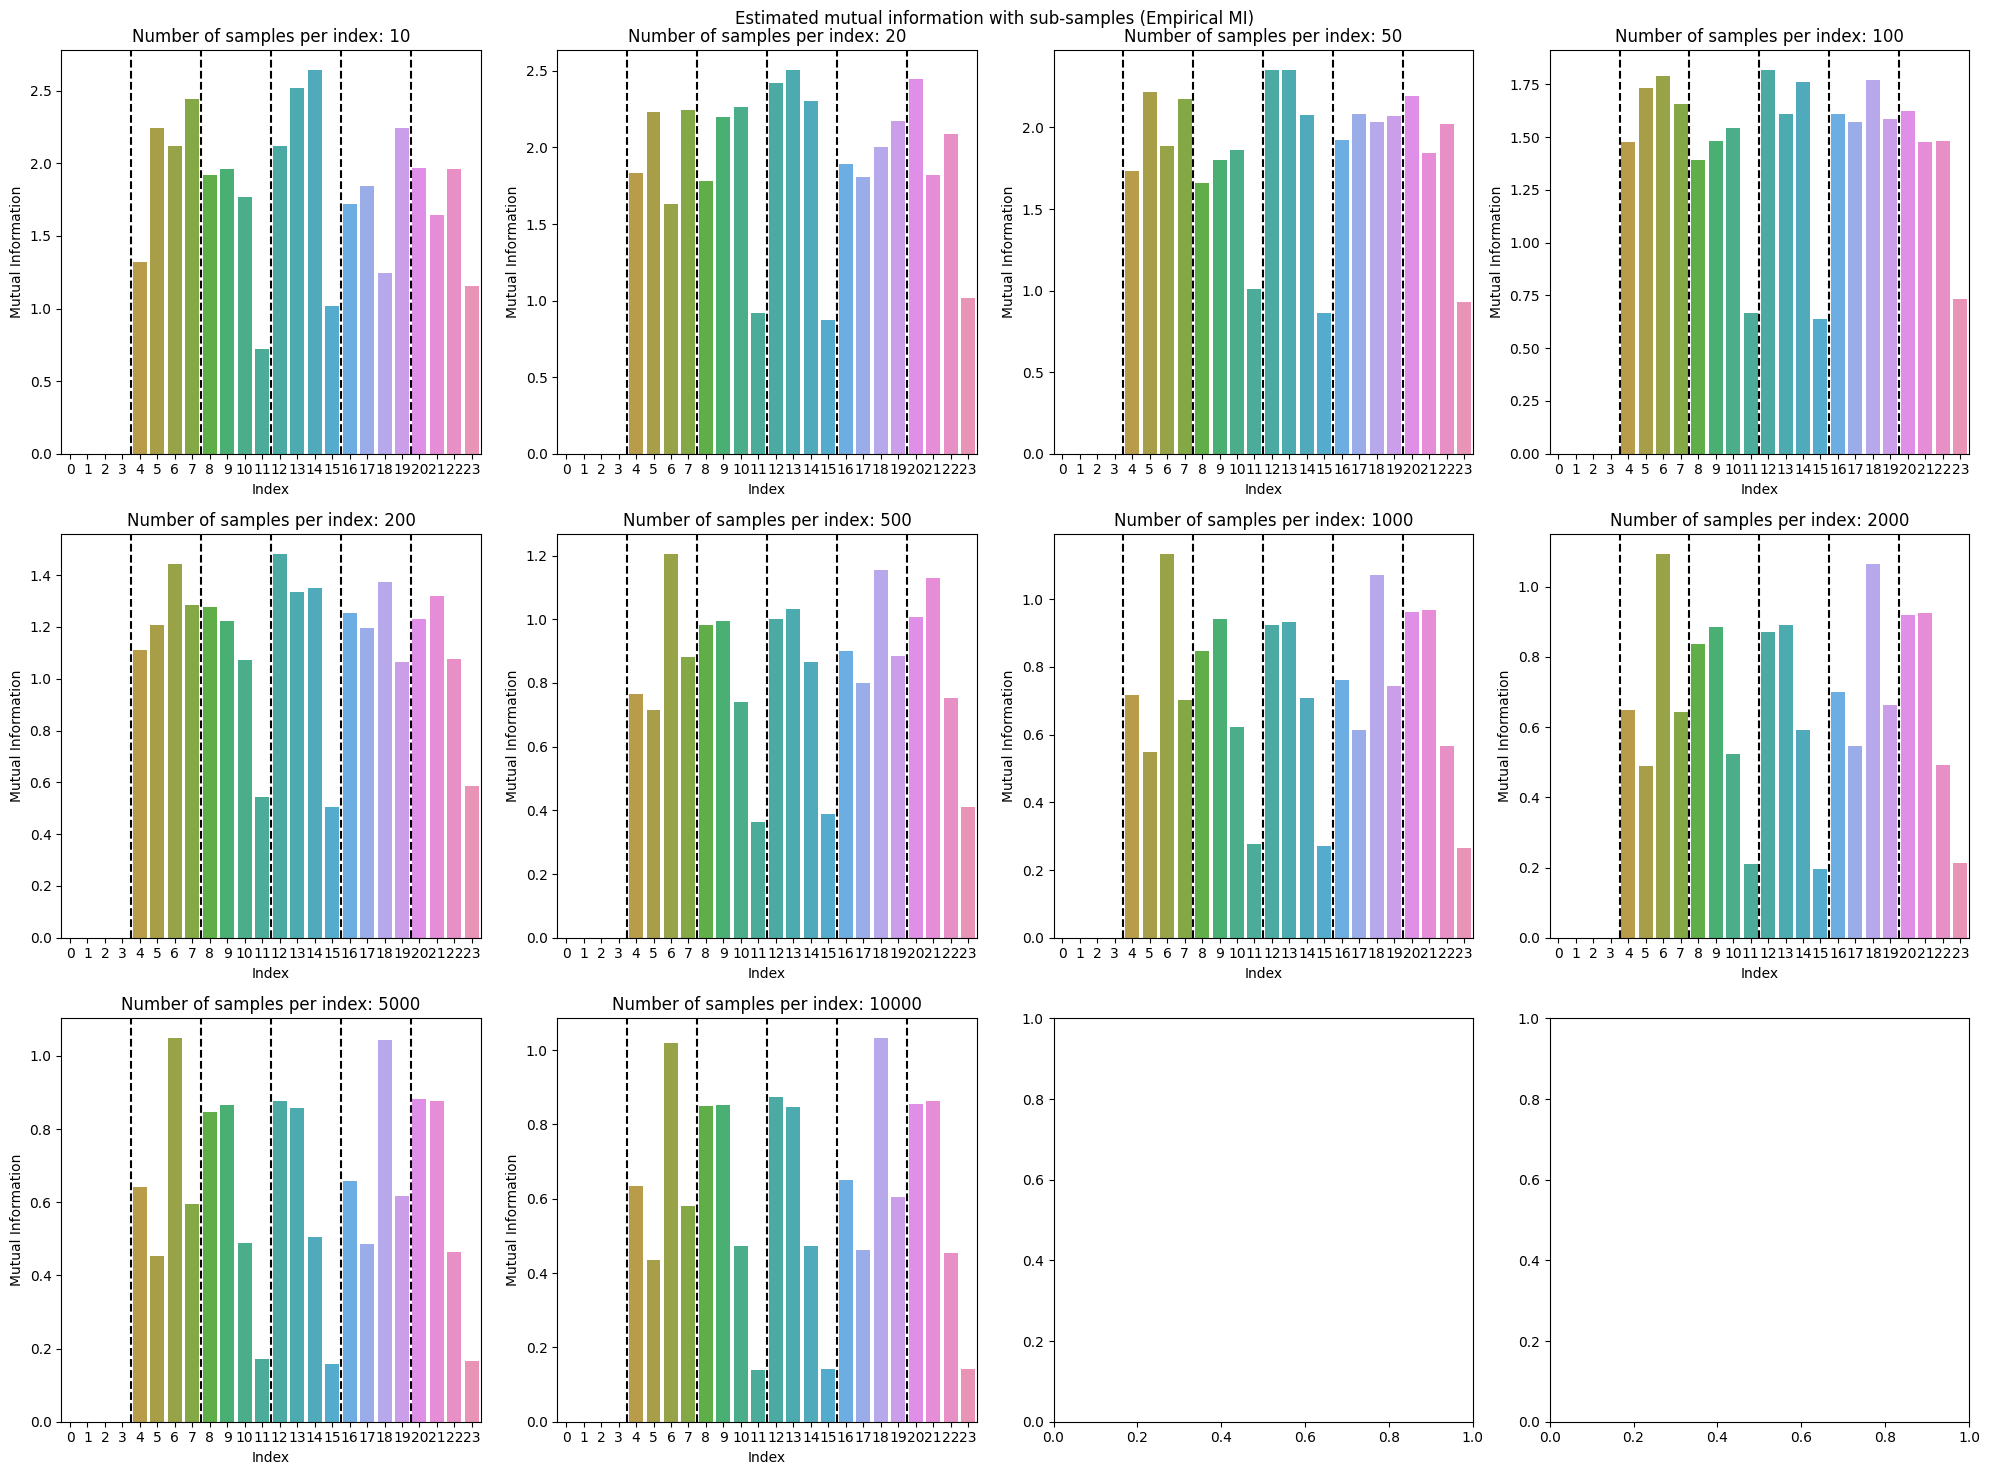

In [235]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_emp(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.suptitle("Estimated mutual information with sub-samples (Empirical MI)")
plt.tight_layout()
plt.savefig("figures/rebuttal/empirical-mi.png")
plt.show()

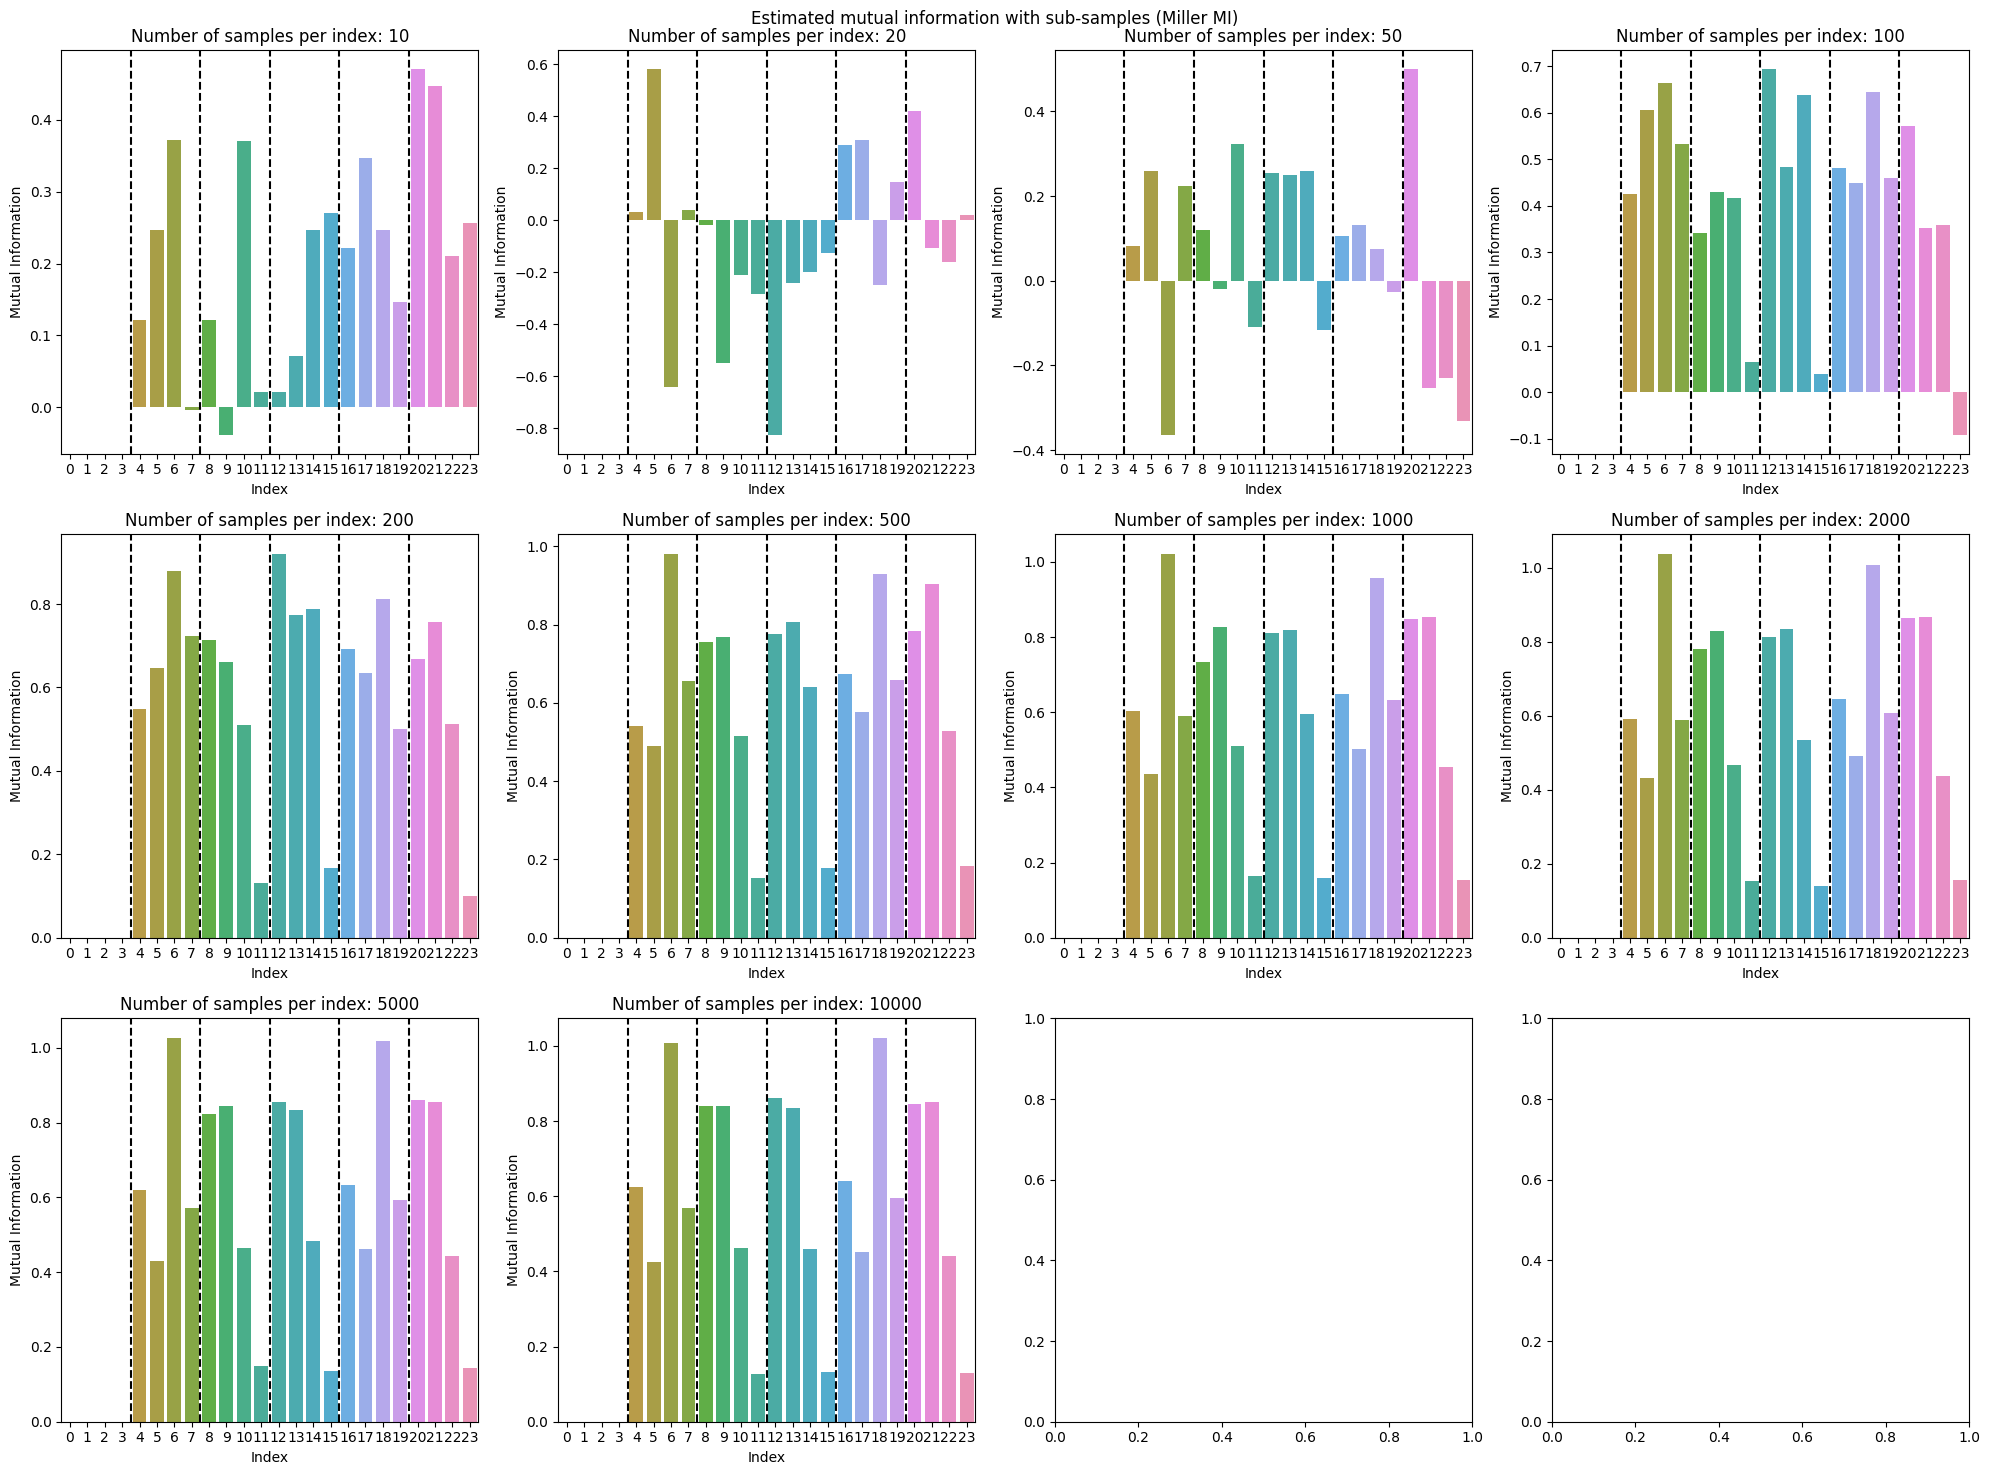

In [236]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_miller(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.suptitle("Estimated mutual information with sub-samples (Miller MI)")
plt.tight_layout()
plt.savefig("figures/rebuttal/miller-mi.png")
plt.show()

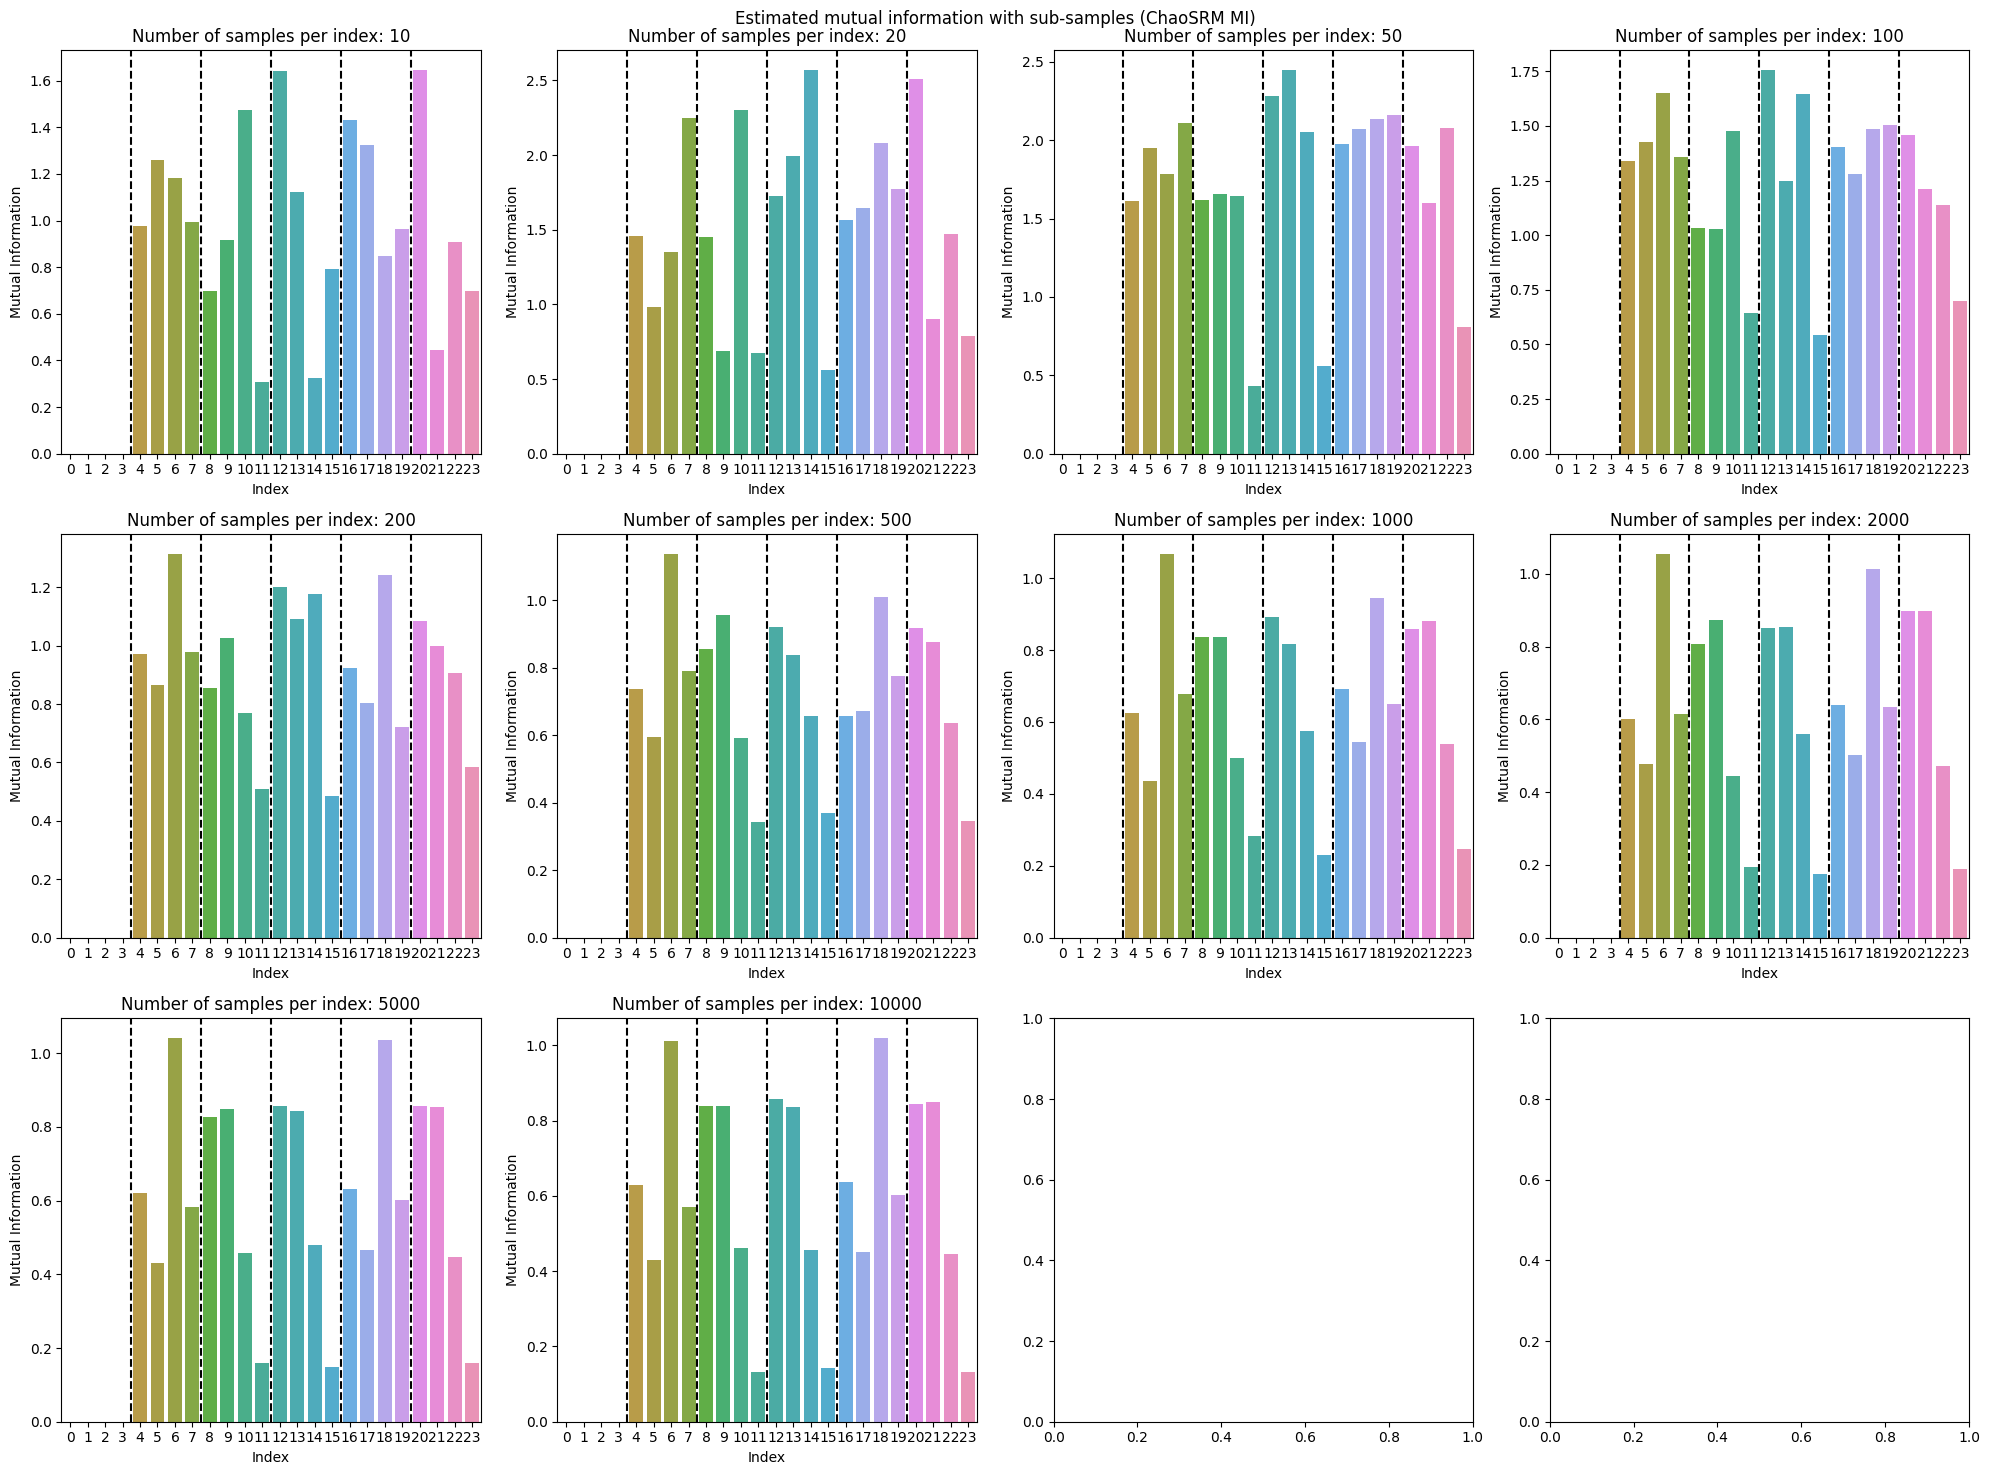

In [237]:
# draw boxplot of mi_data
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
len_prop_ratios = len(prop_ratios)
num_cols = 4
num_rows = (
    len_prop_ratios // num_cols
    if len_prop_ratios % num_cols == 0
    else len_prop_ratios // num_cols + 1
)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
for prop_ratio, ax in zip(prop_ratios, axes.flatten()):
    sns.barplot(
        x=[idx for idx in range(state_length)],
        y=[
            get_mi_chao(
                raw_data[idx][: int(num_state * prop_ratio), 1:],
                domain_size,
                debug=False,
            )
            for idx in range(state_length)
        ],
        ax=ax,
    )
    # vertical line at [3.5, 7.5, 11.5, 15.5, 19.5, 23.5]
    for i in range(1, 6):
        ax.axvline(4 * i - 0.5, color="black", linestyle="--")
    ax.set_xlabel("Index")
    ax.set_ylabel("Mutual Information")
    ax.set_title(f"Number of samples per index: {int(num_state * prop_ratio)}")
plt.suptitle("Estimated mutual information with sub-samples (ChaoSRM MI)")
plt.tight_layout()
plt.savefig("figures/rebuttal/chao-mi.png")
plt.show()

In [223]:
data = []
mi_gt = np.array(
    [get_mi_emp(raw_data[idx][:, 1:]) for idx in range(state_length)]
)
# print(mi_gt)
prop_ratios = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
for prop_ratio in prop_ratios:
    mi_emp = np.array(
        [
            get_mi_emp(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ]
    )
    diff = mi_emp - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("emp", state_length),
                np.arange(state_length),
                mi_emp,
                diff,
            )
        ).T
    )
    mi_miller = np.array(
        [
            get_mi_miller(raw_data[idx][: int(num_state * prop_ratio), 1:])
            for idx in range(state_length)
        ]
    )
    diff = mi_miller - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("miller", state_length),
                np.arange(state_length),
                mi_miller,
                diff,
            )
        ).T
    )
    mi_chao = np.array(
        [
            get_mi_chao(
                raw_data[idx][: int(num_state * prop_ratio), 1:],
                domain_size,
                debug=False,
            )
            for idx in range(state_length)
        ]
    )
    diff = mi_chao - mi_gt
    data.append(
        np.vstack(
            (
                np.repeat(int(num_state * prop_ratio), state_length),
                np.repeat("chao", state_length),
                np.arange(state_length),
                mi_chao,
                diff,
            )
        ).T
    )
diff_df = np.vstack(data)
diff_df = pd.DataFrame(
    diff_df, columns=["n", "method", "idx", "mi", "diff"]
)
diff_df

,n,method,idx,mi,diff
0,10,emp,0,0.0,0.0
1,10,emp,1,0.0,0.0
2,10,emp,2,0.0,0.0
3,10,emp,3,0.0,0.0
4,10,emp,4,2.2464393446710154,1.5823074612029866
...,...,...,...,...,...
715,10000,chao,19,0.5607549052914793,-0.004212164835176502
716,10000,chao,20,0.8535089581245883,-0.018916833860183502
717,10000,chao,21,0.8527905508597984,-0.01789272426183164
718,10000,chao,22,0.449615429159279,-0.01955039415829629


In [60]:
# show min, max, mean, median, MSE
diff_df["n"] = diff_df["n"].astype(int)
# order of method: emp, miller, chao
diff_df["method"] = pd.Categorical(
    diff_df["method"], categories=["emp", "miller", "chao"]
)
diff_df["idx"] = diff_df["idx"].astype(int)
diff_df["mi"] = diff_df["mi"].astype(float)
diff_df["diff"] = diff_df["diff"].astype(float)
diff_df["s.e."] = diff_df["diff"] ** 2
diff_df["noeffect"] = diff_df["mi"] < 0.1
diff_df.groupby(["n", "method"]).agg(
    {"diff": ["mean", "median"], "s.e.": "mean", "noeffect": "sum"}
)

diff                s.e. noeffect
                  mean    median      mean      sum
n     method                                       
10    emp     1.189227  1.404052  1.883599        4
      miller -0.344106 -0.339849  0.243832       11
      chao    0.310701  0.295399  0.229080        4
20    emp     1.251296  1.436538  2.054316        4
      miller -0.624745 -0.691457  0.605633       21
      chao    0.680401  0.737086  0.974317        5
50    emp     1.017609  1.145037  1.302753        4
      miller -0.463641 -0.441369  0.335816       17
      chao    0.958552  1.064169  1.227638        4
100   emp     0.718290  0.809431  0.651208        4
      miller -0.153585 -0.104679  0.053934        6
      chao    0.541941  0.569974  0.384340        4
200   emp     0.421360  0.456530  0.224714        4
      miller -0.023952 -0.004878  0.008995        6
      chao    0.260425  0.285848  0.092147        4
500   emp     0.183817  0.204772  0.044490        4
      miller -0.000558  0.000000  0.003892        4
      chao    0.084955  0.097447  0.012895        4
1000  emp     0.093501  0.115882  0.011969        4
      miller -0.000249  0.003382  0.001478        4
      chao    0.038006  0.019409  0.004498        4
2000  emp     0.046911  0.048792  0.003086        4
      miller  0.000036  0.000000  0.000445        4
      chao    0.015858  0.015701  0.001089        4
5000  emp     0.009028  0.010638  0.000168        4
      miller -0.009722 -0.009935  0.000184        4
      chao   -0.003662 -0.001261  0.000145        4
10000 emp     0.000000  0.000000  0.000000        4
      miller -0.009375 -0.011250  0.000105        4
      chao   -0.007998 -0.008766  0.000095        4

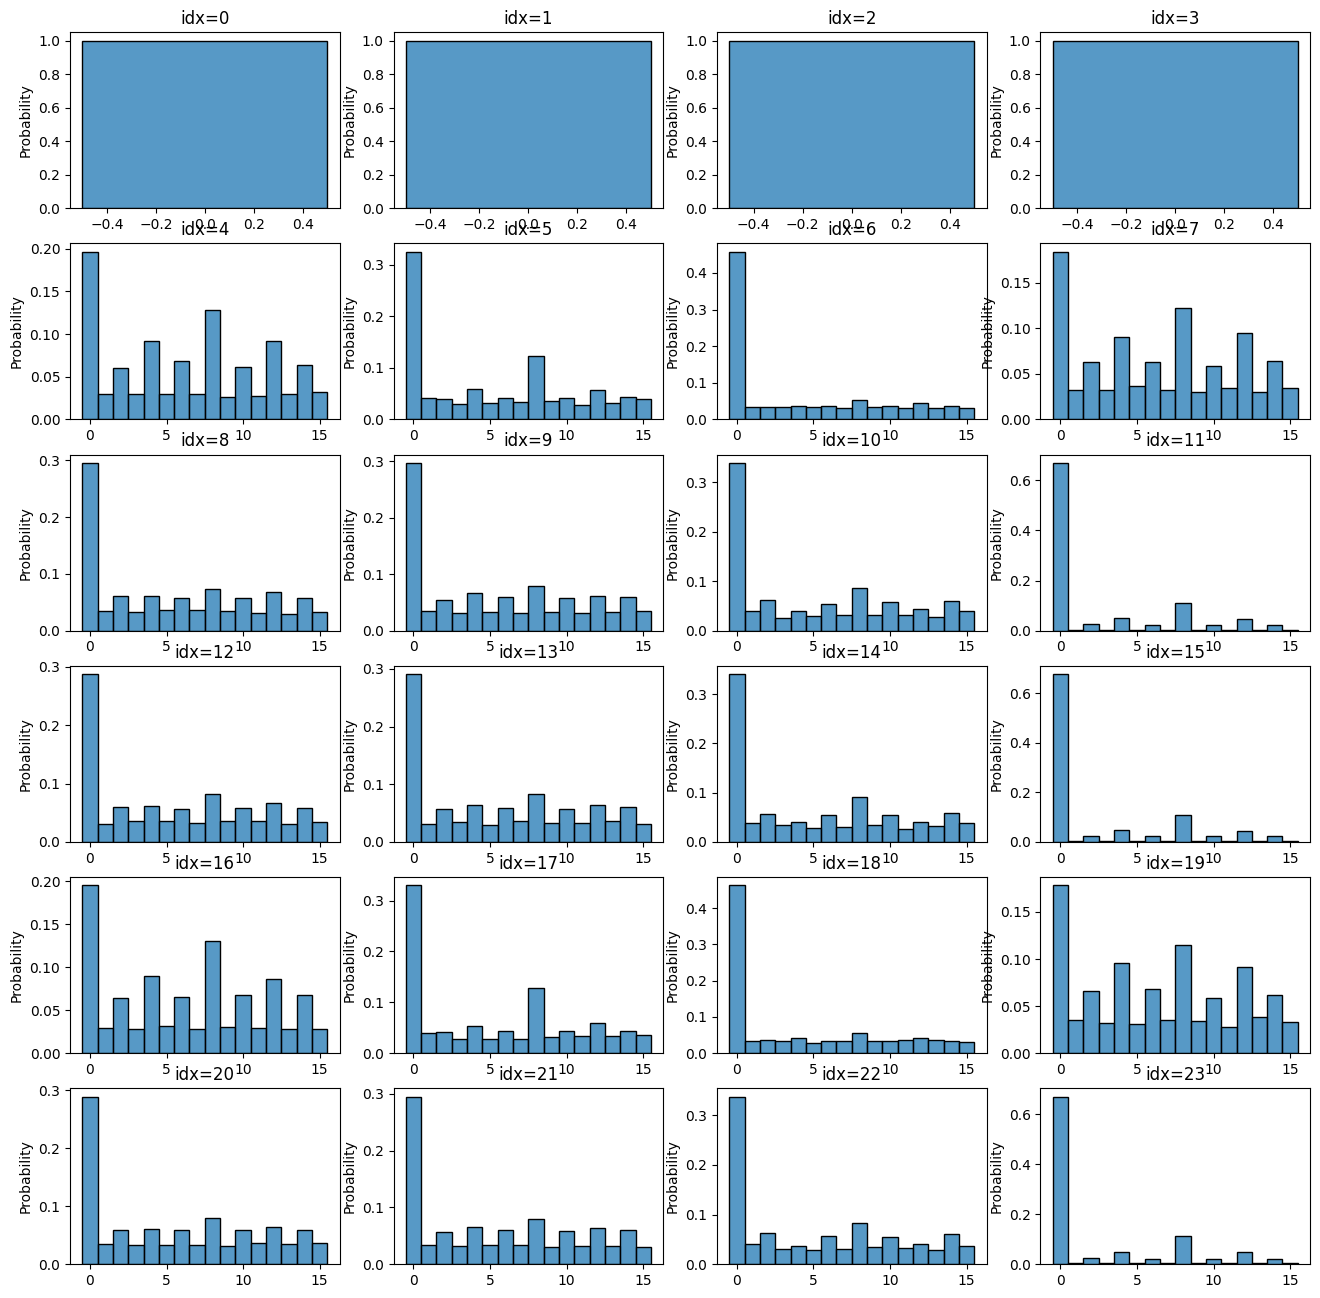

In [19]:
# probability of observables for each secret
fig, axes = plt.subplots(6, 4, figsize=(16, 16))
for idx in range(state_length):
    ax = axes[idx // 4, idx % 4]
    sns.histplot(
        raw_data[idx][:, 2], discrete=True, ax=ax, stat="probability"
    )
    ax.set_title(f"idx={idx}")
plt.show()